In [1]:
import tarfile
import matplotlib.pyplot as plt
import matplotlib  #ajustar
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tensorflow.keras.optimizers import SGD
import metrics
from sklearn.preprocessing import OneHotEncoder
import idx2numpy
import csv

import import_ipynb
from utils import *
from autoencoder_and_clustering_models import *
from read_preprocess_cifar10 import *

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from autoencoder_and_clustering_models.ipynb
importing Jupyter notebook from read_preprocess_cifar10.ipynb


In [2]:
# After download the dataset from  https://www.cs.toronto.edu/~kriz/cifar.html, use these lines to unzip the data
# Change 'arq_path' accordingly
## unzip
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos\cifar-10-python.tar.gz'  # folder where the zipped file is located
#my_tar = tarfile.open(arq_path)
#arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\MeusProjetos'  # specify which folder to extract to
#my_tar.extractall(arq_path) 
#my_tar.close()

In [3]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_1.h5' , input_shape = (32,32,3))

model_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 32, 32, 32)        4736      
_________________________________________________________________
AC_0 (Activation)            (None, 32, 32, 32)        0         
_________________________________________________________________
BN_0 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
max_pool_0 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 16, 16, 16)        12816     
_________________________________________________________________
AC_1 (Activation)            (None, 16, 16, 16)        0         
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 16, 16, 16)        6

In [ ]:
with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
list_indexes = (np.array(list_indexes)).astype(int)


i_crossVal = 0
i_train = np.array([w for w in range(5) if not w == i_crossVal])
indexes_val = list_indexes[i_crossVal]
indexes_train = np.empty(0)
for i in range(len(i_train)):
    indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
indexes_val = np.array(indexes_val)
indexes_train = np.array(indexes_train)

data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset( indexes_train, indexes_val ) 

n_clusters = 10

kmeans = KMeans(n_clusters = n_clusters,max_iter=300, n_init=10,algorithm='full', verbose=1)
kmeans.fit(data_train.reshape((len(data_train),-1)))  # Train K-Means.
y_pred_kmeans = kmeans.predict(data_test.reshape((len(data_test),-1)))  



In [ ]:
arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\cifar10'

print('Confusion Matrix Based on the known Classes')

n_classes = 10
confusion_matrix=confusion_matrix_fn(y_pred_kmeans,np.squeeze(label_test), n_classes = n_classes, n_clusters = n_clusters )
plot_cm(confusion_matrix, arq = arq_path+'\confusionMatrix_originalImage.jpg')
acc,err = accuracy(n_clusters, confusion_matrix)

print('Silhouette of Each Sample per Cluster:')

silhouette_avg = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
silhouette_plot(np.squeeze(y_pred_kmeans),silhouette_avg, sample_silhouette_values, n_clusters, arq = arq_path+'\silhouette_originalImage.jpg')
plt.show()

print ('\nThe accuracy for the test dataset, based on previous known classes is:  %.5f' % (acc*100), '%')
print('\nThe silhouette of the clusterization for the test dateset is:  %.5f' % silhouette_avg)

In [ ]:
n_clusters = 10
n_classes = 10

arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'

with open(arq_path+"\crossValidation_indexes.csv", newline='') as f:
    list_indexes = csv.reader(f)
    list_indexes = list(list(rec) for rec in csv.reader(f, delimiter=','))
list_indexes = (np.array(list_indexes)).astype(int)

arq_path_2 = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\cifar10'

test_accuracy = np.zeros((5))
test_silhouette_avg = np.zeros((5))

for i_crossVal in range(5):
    
    print('\n \n ')
    print('\t \t \t Results Validated with Batch ', i_crossVal, ' Dataset\n')
    
    i_train = np.array([w for w in range(5) if not w == i_crossVal])
    indexes_val = list_indexes[i_crossVal]
    indexes_train = np.empty(0)
    for i in range(len(i_train)):
        indexes_train = np.concatenate ((indexes_train, list_indexes[i_train[i]]), axis=0 )
    indexes_val = np.array(indexes_val)
    indexes_train = np.array(indexes_train)
    data_train, data_val, data_test, label_train, label_val, label_test = read_preprocess_dataset( indexes_train, indexes_val ) 



    model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', input_shape = (32,32,3))
    
    
    y_hat_train = model_encoder.predict( data_train )
    y_hat_test = model_encoder.predict( data_test )
    
    
    kmeans = KMeans(n_clusters=n_clusters,max_iter=300, n_init=10,algorithm='full', verbose=0)
    kmeans.fit(y_hat_train)  # Train K-Means.
    y_pred_kmeans = kmeans.predict(y_hat_test)  

    confusion_matrix=confusion_matrix_fn(y_pred_kmeans,np.squeeze(label_test), n_classes=n_classes, n_clusters=n_clusters )
    plot_cm(confusion_matrix, arq = arq_path_2 +'\confusionMatrix_encodedImage_CNN_'+str(i_crossVal)+'.jpg')
    test_accuracy[i_crossVal],err = accuracy(n_clusters, confusion_matrix)
    print('Accuracy = ',test_accuracy[i_crossVal]*100,'% - Error = ',err*100, '%')
    
    
    print ('\n')
    
    test_silhouette_avg[i_crossVal] = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
    sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred_kmeans),metric='euclidean')
    silhouette_plot(np.squeeze(y_pred_kmeans),silhouette_avg, sample_silhouette_values, n_clusters,  arq = arq_path_2+'\silhouette__encodedImage_CNN_'+str(i_crossVal)+'.jpg')
    plt.show()
    
test_accuracy_mean = np.mean(test_accuracy)
test_accuracy_std = np.std(test_accuracy)

test_silhouette_avg_mean = np.mean(test_silhouette_avg)
test_silhouette_avg_std = np.std(test_silhouette_avg)

print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))

D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_1
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_2
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_3
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_4
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\data_batch_5
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\/test_batch
D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\autoencoder\cifar10\cifar-10-batches-py\batches.meta


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.23752, nmi = 0.11307, ari = 0.05827  ; loss= 0


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 140: acc = 0.23252, nmi = 0.11095, ari = 0.05837  ; loss= 0.0091


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 280: acc = 0.22635, nmi = 0.10634, ari = 0.05646  ; loss= 0.0247


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 420: acc = 0.21315, nmi = 0.09901, ari = 0.05113  ; loss= 0.05816


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 560: acc = 0.20612, nmi = 0.09553, ari = 0.04967  ; loss= 0.10068


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 700: acc = 0.19310, nmi = 0.08599, ari = 0.04438  ; loss= 0.12645


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 840: acc = 0.18672, nmi = 0.07908, ari = 0.03923  ; loss= 0.13133


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 980: acc = 0.18332, nmi = 0.07267, ari = 0.03495  ; loss= 0.13161


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1120: acc = 0.18270, nmi = 0.06983, ari = 0.03378  ; loss= 0.17058


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1260: acc = 0.18262, nmi = 0.06754, ari = 0.03265  ; loss= 0.16246


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1400: acc = 0.18025, nmi = 0.06611, ari = 0.03079  ; loss= 0.16822


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1540: acc = 0.18428, nmi = 0.06929, ari = 0.03579  ; loss= 0.21768


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1680: acc = 0.18758, nmi = 0.07097, ari = 0.03780  ; loss= 0.18256


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1820: acc = 0.18678, nmi = 0.07061, ari = 0.03782  ; loss= 0.17246


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1960: acc = 0.18538, nmi = 0.06721, ari = 0.03451  ; loss= 0.20756


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2100: acc = 0.18355, nmi = 0.06619, ari = 0.03277  ; loss= 0.2124


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2240: acc = 0.18515, nmi = 0.06705, ari = 0.03458  ; loss= 0.17118


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2380: acc = 0.18635, nmi = 0.06904, ari = 0.03727  ; loss= 0.17135


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2520: acc = 0.18588, nmi = 0.06870, ari = 0.03642  ; loss= 0.17015


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2660: acc = 0.18272, nmi = 0.06804, ari = 0.03499  ; loss= 0.18587


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2800: acc = 0.18208, nmi = 0.06841, ari = 0.03609  ; loss= 0.15705


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2940: acc = 0.17752, nmi = 0.06928, ari = 0.03413  ; loss= 0.1823


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3080: acc = 0.17510, nmi = 0.06954, ari = 0.03316  ; loss= 0.14009


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3220: acc = 0.17568, nmi = 0.06735, ari = 0.03175  ; loss= 0.14688


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3360: acc = 0.17650, nmi = 0.06595, ari = 0.03104  ; loss= 0.15105


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3500: acc = 0.17530, nmi = 0.06408, ari = 0.02974  ; loss= 0.15559


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3640: acc = 0.17310, nmi = 0.06301, ari = 0.02799  ; loss= 0.15682


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3780: acc = 0.17485, nmi = 0.06232, ari = 0.02767  ; loss= 0.20554


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3920: acc = 0.17572, nmi = 0.06206, ari = 0.02795  ; loss= 0.15609


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4060: acc = 0.17452, nmi = 0.06300, ari = 0.02872  ; loss= 0.13513


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4200: acc = 0.17868, nmi = 0.06287, ari = 0.03047  ; loss= 0.188


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4340: acc = 0.17845, nmi = 0.06055, ari = 0.02946  ; loss= 0.15489


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4480: acc = 0.18155, nmi = 0.06165, ari = 0.03108  ; loss= 0.19025


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4620: acc = 0.17522, nmi = 0.05957, ari = 0.02806  ; loss= 0.17546


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4760: acc = 0.17722, nmi = 0.06081, ari = 0.02995  ; loss= 0.21886


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4900: acc = 0.17840, nmi = 0.06287, ari = 0.03207  ; loss= 0.16643


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5040: acc = 0.17960, nmi = 0.06266, ari = 0.03219  ; loss= 0.15187


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5180: acc = 0.17795, nmi = 0.06260, ari = 0.03228  ; loss= 0.13701


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5320: acc = 0.17910, nmi = 0.06320, ari = 0.03320  ; loss= 0.14575


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5460: acc = 0.18118, nmi = 0.06249, ari = 0.03272  ; loss= 0.16651


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5600: acc = 0.18200, nmi = 0.06338, ari = 0.03383  ; loss= 0.16338


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5740: acc = 0.18082, nmi = 0.06347, ari = 0.03359  ; loss= 0.17149


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5880: acc = 0.18215, nmi = 0.06628, ari = 0.03625  ; loss= 0.18404


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6020: acc = 0.18295, nmi = 0.06677, ari = 0.03654  ; loss= 0.16404


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6160: acc = 0.18205, nmi = 0.06647, ari = 0.03602  ; loss= 0.15435


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6300: acc = 0.18450, nmi = 0.06622, ari = 0.03607  ; loss= 0.13571


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6440: acc = 0.18420, nmi = 0.06467, ari = 0.03487  ; loss= 0.14788


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6580: acc = 0.18400, nmi = 0.06526, ari = 0.03511  ; loss= 0.1793


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6720: acc = 0.18442, nmi = 0.06469, ari = 0.03371  ; loss= 0.15999


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6860: acc = 0.18462, nmi = 0.06423, ari = 0.03310  ; loss= 0.15054


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7000: acc = 0.18375, nmi = 0.06506, ari = 0.03394  ; loss= 0.1413


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7140: acc = 0.18315, nmi = 0.06418, ari = 0.03342  ; loss= 0.15334


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7280: acc = 0.18250, nmi = 0.06464, ari = 0.03383  ; loss= 0.15538


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7420: acc = 0.18212, nmi = 0.06440, ari = 0.03353  ; loss= 0.15548


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7560: acc = 0.18305, nmi = 0.06546, ari = 0.03472  ; loss= 0.14631


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7700: acc = 0.18362, nmi = 0.06610, ari = 0.03540  ; loss= 0.13759


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7840: acc = 0.18300, nmi = 0.06682, ari = 0.03607  ; loss= 0.15639


D:\Programas\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
D:\Programas\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 7980: acc = 0.18295, nmi = 0.06720, ari = 0.03674  ; loss= 0.17588


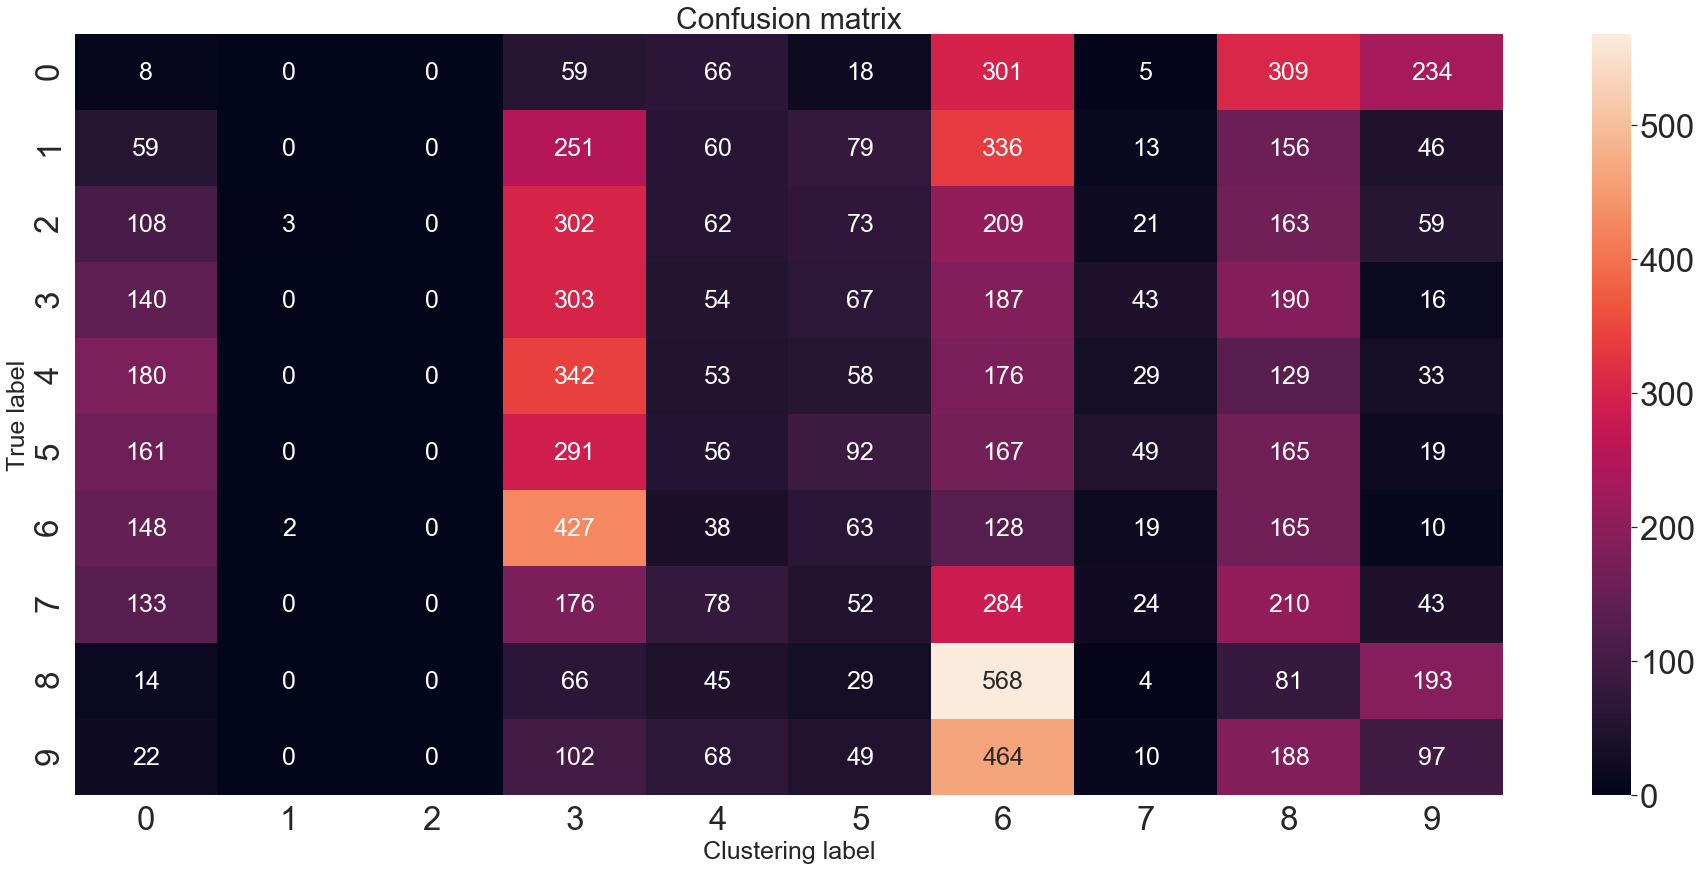

Accuracy =  18.295
Error =  80.60000000000001


NameError: name 'silhouette_avg' is not defined

In [4]:



n_clusters = 10
n_classes = 10

arq_path = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\\autoencoder\cifar10'
arq_path_2 = 'D:\Luiza\OneDrive\Documentos\Doutorado\MeusProjetos\deep_clustering\cifar10'


test_accuracy = np.zeros((5))
test_silhouette_avg = np.zeros((5))

batch = load_data (arq_path)

for i_crossVal in range(5):
    

    i_train = np.array([w for w in range(5) if not w == i_crossVal])
    data_train, data_val, data_test, label_train, label_val, label_test = datasets_crossValitation (batch, i_train, i_crossVal=i_crossVal)

    
    model, model_encoder = deep_clustering_model(arq_path + '\Encoder_model_'+str(i_crossVal)+'.h5', input_shape = (32,32,3))
    
    clustering_layer = ClusteringLayer(n_clusters, name='clustering')(model_encoder.output)
    model = Model(inputs=model_encoder.input, outputs=clustering_layer)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_pred = kmeans.fit_predict(model_encoder.predict(data_train))


    y_pred_last = np.copy(y_pred)
    model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9), loss='kld')
    
    batch_size = 256

    loss = 0
    index = 0
    maxiter = 8000
    update_interval = 140
    index_array = np.arange(data_train.shape[0])

    tol = 0.001 # tolerance threshold to stop training


    for ite in range(int(maxiter)):
    
        
        if ite % update_interval == 0:
            q = model.predict(data_train, verbose=0)
            p = target_distribution(q)  # update the auxiliary target distribution p

            # evaluate the clustering performance
            y_pred = q.argmax(1)
            if label_train is not None:
                acc = np.round(metrics.acc(np.squeeze(label_train), y_pred), 5)
                nmi = np.round(metrics.nmi(np.squeeze(label_train), y_pred), 5)
                ari = np.round(metrics.ari(np.squeeze(label_train), y_pred), 5)
                loss = np.round(loss, 5)
                print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

            # check stop criterion - model convergence
            delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
            y_pred_last = np.copy(y_pred)
            if ite > 0 and delta_label < tol:
                print('delta_label ', delta_label, '< tol ', tol)
                print('Reached tolerance threshold. Stopping training.')
                break
        idx = index_array[index * batch_size: min((index+1) * batch_size, data_train.shape[0])]
        loss = model.train_on_batch(x=data_train[idx], y=p[idx])
        index = index + 1 if (index + 1) * batch_size <= data_train.shape[0] else 0

    model.save(arq_path_2 + '\Keras_Deep_Clustering_model_'+str(i_crossVal)+'.h5')





    # evaluate the clustering performance
    q = model.predict(data_test, verbose=0)
    y_pred = q.argmax(1)
    # Evaluate the K-Means clustering accuracy.
    confusion_matrix = confusion_matrix_fn(y_pred,np.squeeze(label_test), n_classes=n_classes, n_clusters=n_clusters)
    test_accuracy[i_crossVal],error = accuracy(n_clusters, confusion_matrix)
    plot_cm(confusion_matrix, arq=arq_path_2+'\confusioMatrix_KerasDeepClusteringModel_'+str(i_crossVal)+'.jpg')
    plt.show()

    print('Accuracy = ',acc*100)
    print('Error = ', error*100)

    test_silhouette_avg[i_crossVal] = silhouette_score(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred),metric='euclidean')
    sample_silhouette_values = silhouette_samples(data_test.reshape((len(data_test),-1)), np.squeeze(y_pred),metric='euclidean')
    silhouette_plot(np.squeeze(y_pred),silhouette_avg, sample_silhouette_values, n_clusters, arq=arq_path_2+'\silhouette_KerasDeepClusteringModel_'+str(i_crossVal)+'.jpg')
    plt.show()
    
test_accuracy_mean = np.mean(test_accuracy)
test_accuracy_std = np.std(test_accuracy)

test_silhouette_avg_mean = np.mean(test_silhouette_avg)
test_silhouette_avg_std = np.std(test_silhouette_avg)
    
print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))

In [ ]:
print ('\nThe mean accuracy, based on previous known classes, for the test dataset using cross-validation is equal to %.5f %%, with standard deviation equal to %.5f %%' %(test_accuracy_mean*100, test_accuracy_std*100))
print('\nThe mean silhouette of the clusterization for the test dateset using cross-validation is equal to %.5f, with standard deviation equal to %.5f' %(test_silhouette_avg_mean, test_silhouette_avg_std))